In [102]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

In [103]:
raw_df = pd.read_csv('dataset/weatherAUS.csv')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Visualisation of different datas

In [104]:
unique_locations = raw_df['Location'].nunique()

fig = px.histogram(
    raw_df,
    x='Location',
    color='RainToday'
)
fig.update_layout(bargap=0.3)
fig.show()

In [105]:
# MinTemp vs RainToday
fig = px.histogram(
    raw_df,
    x='MinTemp',
    color='RainToday'
)
fig.update_layout(bargap=0.3)
fig.show()

# MaxTemp vs RainToday
fig = px.histogram(
    raw_df,
    x='MaxTemp',
    color='RainTomorrow',
)
fig.update_layout(bargap=0.3)
fig.show()

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

#### Data preprocessing

Train and test split

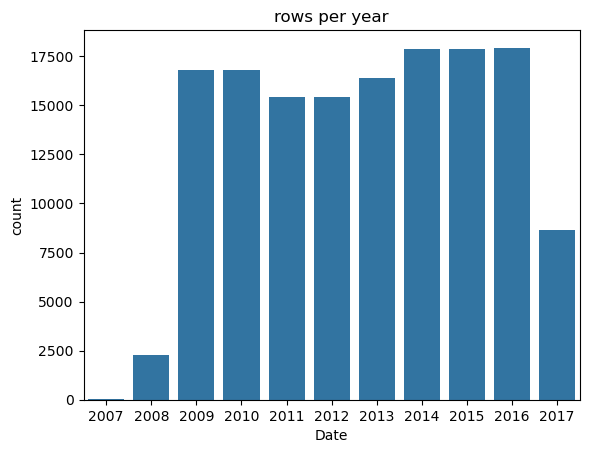

In [106]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=50)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=50)

# print(f'train_df: {train_df.shape}')
# print(f'val_df: {val_df.shape}')
# print(f'test_df: {test_df.shape}')
years = pd.to_datetime(raw_df['Date']).dt.year

train_df = raw_df[years < 2015]
val_df = raw_df[years == 2015]
test_df = raw_df[years > 2015]

## Show years
plt.title('rows per year')
sns.countplot(x=years)
plt.show()

Input and target set

In [107]:
raw_df.columns
input_cols = list(train_df.columns)[1: -1]
target_cols = 'RainTomorrow'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_cols].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_cols].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_cols].copy()

# get the numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

Imputing the missing value

In [108]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)

total_missing_values = raw_df[numeric_cols].isna().sum()

train_missing_val = train_df[numeric_cols].isna().sum()
val_missing_val = val_df[numeric_cols].isna().sum()
test_missing_val = test_df[numeric_cols].isna().sum()

imputer.fit(raw_df[numeric_cols])

train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

# CHECK
# test_inputs[numeric_cols].isna().sum()

Scale numeric feature

In [125]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(raw_df[numeric_cols])

train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])


Encoding categorical data

In [144]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

data_df = raw_df[categorical_cols].fillna('Unknown')
encoder.fit(data_df)

encoded_cols = encoder.get_feature_names_out(categorical_cols).tolist()

train_inputs[categorical_cols] = train_inputs[categorical_cols].fillna('Unknown').copy()
val_inputs[categorical_cols] = val_inputs[categorical_cols].fillna('Unknown').copy()
test_inputs[categorical_cols] = test_inputs[categorical_cols].fillna('Unknown').copy()

train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

#### Model

In [145]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')

# train_inputs = pd.read_parquet('lr_01_train_inputs.parquet')
# val_inputs = pd.read_parquet('lr_01_val_inputs.parquet')
# test_inputs = pd.read_parquet('lr_01_test_inputs.parquet')

# train_targets = pd.read_parquet('lr_01_train_targets.parquet')
# val_targets = pd.read_parquet('lr_01_val_targets.parquet')
# test_targets = pd.read_parquet('lr_01_test_targets.parquet')

X = train_inputs[numeric_cols + encoded_cols]
y = train_targets

model.fit(X, y)

/home/sudiptoshahin/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LogisticRegression(solver='liblinear')

Cost / Loss

In [158]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


def cost_function(hx, y):
    # hx => predicted value
    # y => actual value
    cost = np.dot(-y, np.log(hx)) - np.dot((1-y), np.log(1 - hx))

    return cost

def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    accuracy = accuracy_score(targets, preds)
    print('Accuracy: {:.2f}%'.format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion matrix'.format(name))

    return preds

Accuracy: 85.19%
Accuracy: 84.20%


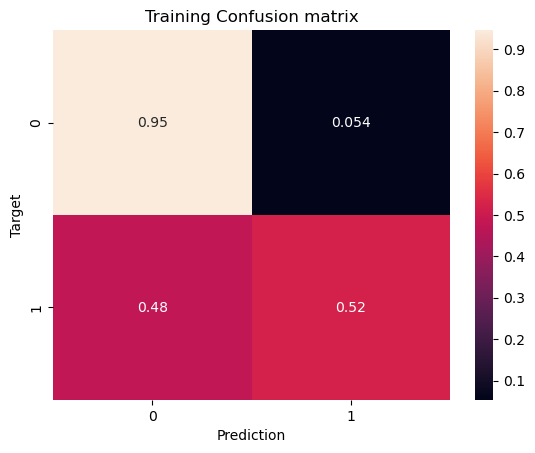

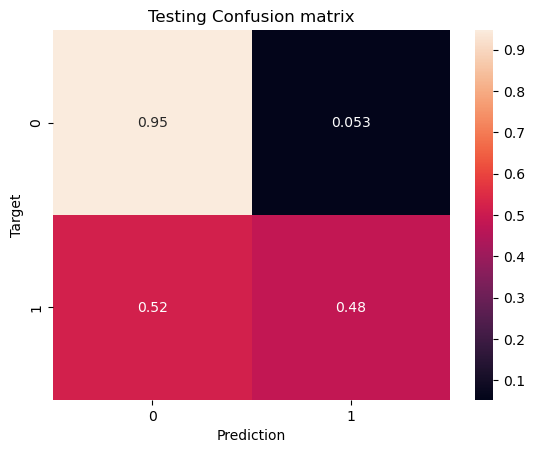

In [162]:
X_train = train_inputs[numeric_cols+encoded_cols]
X_val = val_inputs[numeric_cols+encoded_cols]
X_test = test_inputs[numeric_cols+encoded_cols]

predictions = model.predict(X_test)

# cost_function(predictions, test_targets)

train_preds = predict_and_plot(X_train, train_targets, 'Training')
test_preds = predict_and_plot(X_test, test_targets, 'Testing')